In [39]:
# import libraries
import pandas as pd
import numpy as np

# load the data set
from datasets import load_dataset

# for plot
import matplotlib.pyplot as plt

# scaling the data
from sklearn.preprocessing import MinMaxScaler

# LSTM implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

In [2]:
df_train = load_dataset("mrseba/currency_data_project")

df = df_train['train'].to_pandas()

Found cached dataset csv (C:/Users/user/.cache/huggingface/datasets/mrseba___csv/mrseba--currency_data_project-ceabd9c88c543363/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
df

,Date,EUR,RON,RUB,UAH,USD
0,2021-01-01,21.1266,4.3340,0.2312,0.6075,17.2146
1,2021-01-02,21.1266,4.3340,0.2312,0.6075,17.2146
2,2021-01-03,21.1266,4.3340,0.2312,0.6075,17.2146
3,2021-01-04,21.0998,4.3345,0.2298,0.6067,17.1913
4,2021-01-05,21.1326,4.3398,0.2341,0.6044,17.1886
...,...,...,...,...,...,...
998,2023-09-26,19.3622,3.8980,0.1894,0.4929,18.2026
999,2023-09-27,19.2489,3.8734,0.1888,0.4919,18.1679
1000,2023-09-28,19.1542,3.8502,0.1876,0.4914,18.1471
1001,2023-09-29,19.1338,3.8458,0.1871,0.4916,18.1553


In [4]:
df.describe()

,EUR,RON,RUB,UAH,USD
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,20.235515,4.105428,0.251088,0.583329,18.277175
std,0.720689,0.154855,0.042800,0.070709,0.678374
min,18.716200,3.782500,0.131900,0.474100,17.188600
25%,19.740850,4.003200,0.230500,0.513800,17.732150
50%,20.164300,4.080800,0.240800,0.617200,18.011000
75%,20.748700,4.207000,0.272300,0.649100,18.974400
max,21.690200,4.402400,0.362800,0.673800,19.598400


### analize the date

In [22]:
# Convert the 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)  

In [23]:
# df_usd = df[['Date', 'USD']].copy()
df_usd = df[['USD']].copy()

In [24]:
df_usd

,USD
Date,
2021-01-01,17.2146
2021-01-02,17.2146
2021-01-03,17.2146
2021-01-04,17.1913
2021-01-05,17.1886
...,...
2023-09-26,18.2026
2023-09-27,18.1679
2023-09-28,18.1471


In [7]:
# df_usd['Date'] = pd.to_datetime(df_usd['Date'])  # Convert the 'Date' column to datetime format

# df_usd.set_index('Date', inplace=True)       # Set the 'Date' column as the index

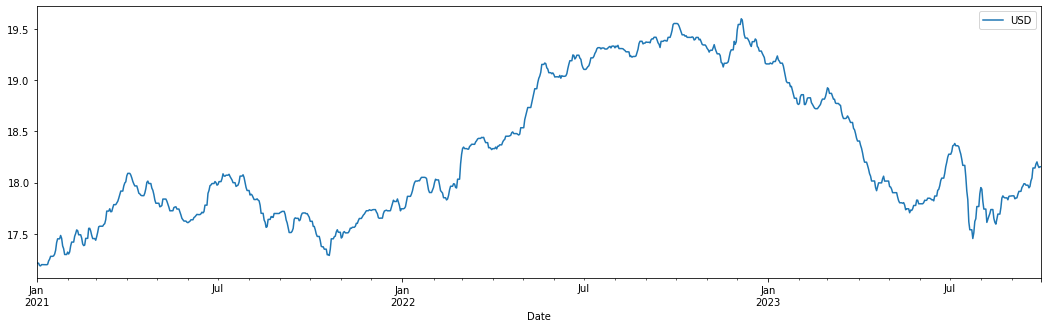

In [25]:
df_usd.plot(figsize=(18, 5))
plt.show()

In [26]:
# select the data for the plot    
tstart = 2021
tend = 2023

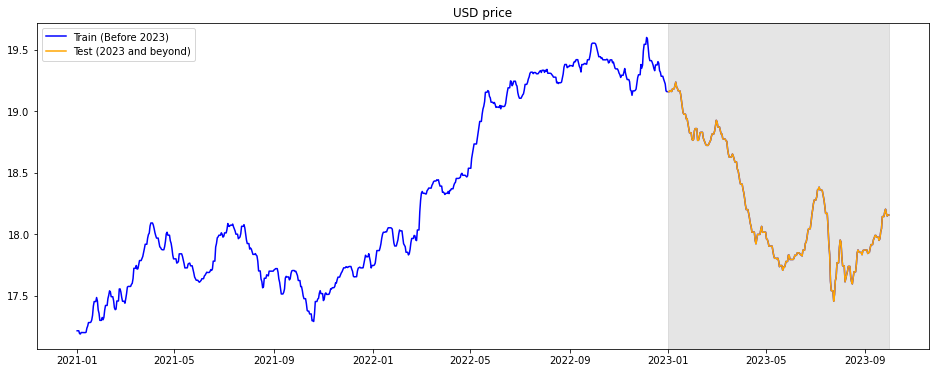

In [27]:
def train_test_plot(dataset, tstart, tend):
    plt.figure(figsize=(16, 6))
    
    # Plotting the entire dataset
    plt.plot(dataset.index, dataset["USD"], label=f"Train (Before {tend})", color='blue')
    
    # Find the start date for the test set
    test_start_date = dataset.index[dataset.index >= f"{tend}-01-01"][0]
    
    # Plotting the "test" part
    plt.plot(dataset.loc[test_start_date:].index, dataset.loc[test_start_date:,"USD"], label=f"Test ({tend} and beyond)", color='orange')
    
    # Shading the region for the test set
    plt.axvspan(test_start_date, dataset.index[-1], color='grey', alpha=0.2)
    
    plt.legend()
    plt.title("USD price")
    plt.show()
    
train_test_plot(df_usd, tstart, tend)

### prepare the date for the model

In [28]:
def train_test_split(dataset, tstart, tend):
    
    tstart = pd.Timestamp(tstart)
    tend = pd.Timestamp(tend)
    
    train = dataset.loc[tstart:tend, "USD"].values
    
    next_day = tend + pd.Timedelta(days=1)
    
    test = dataset.loc[next_day:, "USD"].values
    
    return train, test

In [29]:
df_usd

,USD
Date,
2021-01-01,17.2146
2021-01-02,17.2146
2021-01-03,17.2146
2021-01-04,17.1913
2021-01-05,17.1886
...,...
2023-09-26,18.2026
2023-09-27,18.1679
2023-09-28,18.1471


In [48]:
def train_test_split(dataset, tstart, tend):
    
    # Ensure tstart and tend are in the correct format as string
    tstart = pd.to_datetime(tstart)
    tend = pd.to_datetime(tend)
    
    # The dataset should already have 'Date' as its index at this point
    train = dataset.loc[tstart:tend].values
    
    next_day = tend + pd.Timedelta(days=1)
    
    test = dataset.loc[next_day:].values
    
    # Check if train or test sets are empty and raise an error if they are
    if train.size == 0:
        raise ValueError(f"No data available in the range {tstart} to {tend}.")
    if test.size == 0:
        raise ValueError(f"No data available after {tend}.")
    
    return train, test

# The tstart and tend should be passed as strings in 'YYYY-MM-DD' format
tstart = '2021-01-01'
tend = '2023-01-01'

# Use the function to split the data
training_set, test_set = train_test_split(df_usd, tstart, tend)

# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))


In [49]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence) - n_steps):
        seq_x, seq_y = sequence[i:i+n_steps], sequence[i+n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [50]:
n_steps = 60
X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Reshaping X_train for the model
features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [51]:
# Remodelarea X_train pentru model
features = 1
X_train.reshape(X_train.shape[0],X_train.shape[1],features)

array([[[0.01078928],
        [0.01078928],
        [0.01078928],
        ...,
        [0.1103826 ],
        [0.1103826 ],
        [0.10370155]],

       [[0.01078928],
        [0.01078928],
        [0.00112042],
        ...,
        [0.1103826 ],
        [0.10370155],
        [0.11880654]],

       [[0.01078928],
        [0.00112042],
        [0.        ],
        ...,
        [0.10370155],
        [0.11880654],
        [0.13623537]],

       ...,

       [[0.88841398],
        [0.87961657],
        [0.87451241],
        ...,
        [0.85189642],
        [0.84318201],
        [0.81969458]],

       [[0.87961657],
        [0.87451241],
        [0.86509254],
        ...,
        [0.84318201],
        [0.81969458],
        [0.81720475]],

       [[0.87451241],
        [0.86509254],
        [0.87239605],
        ...,
        [0.81969458],
        [0.81720475],
        [0.81720475]]])

In [52]:
# Arhitectura
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compilarea modelului
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [53]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
21/21 [==============================] - 3s 31ms/step - loss: 0.0254
Epoch 2/50
21/21 [==============================] - 1s 30ms/step - loss: 0.0042
Epoch 3/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0032
Epoch 4/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0017
Epoch 5/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 6/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0018
Epoch 7/50
21/21 [==============================] - 1s 28ms/step - loss: 0.0020
Epoch 8/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0020
Epoch 9/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0018
Epoch 10/50
21/21 [==============================] - 1s 30ms/step - loss: 0.0017
Epoch 11/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0012
Epoch 12/50
21/21 [==============================] - 1s 28ms/step - loss: 0.0015
Epoch 13/50
21/21 [==================

9/9 [==============================] - 1s 12ms/step


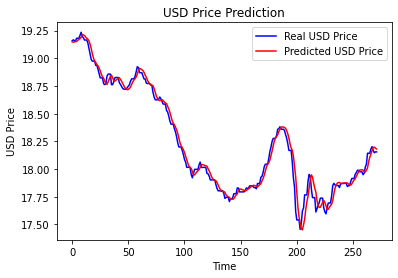

The root mean squared error is 0.06.


In [55]:
# First, let's ensure we have imported the necessary additional library for mean_squared_error
from sklearn.metrics import mean_squared_error

# We will also need to update the dataset_total to reflect your actual column 'USD'
dataset_total = df_usd['USD']

# Preparing the inputs for prediction by taking the last n_steps from the training set and the test set
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps:].values
inputs = inputs.reshape(-1, 1)
# Scaling the inputs
inputs = sc.transform(inputs)

# Split the inputs into samples
X_test, y_test = split_sequence(inputs, n_steps)
# Reshape the test set for the LSTM [samples, time steps, features]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Making predictions
predicted_usd_price = model_lstm.predict(X_test)
# Inverse transforming the predictions to get actual values
predicted_usd_price = sc.inverse_transform(predicted_usd_price)

# Plotting the results
def plot_predictions(test, predicted):
    plt.plot(test, color="blue", label="Real USD Price")
    plt.plot(predicted, color="red", label="Predicted USD Price")
    plt.title("USD Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("USD Price")
    plt.legend()
    plt.show()

# Computing the RMSE
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

# Plotting the predictions
plot_predictions(test_set, predicted_usd_price)

# Calculating the RMSE
return_rmse(test_set, predicted_usd_price)


In [56]:
# Assuming `df_usd` is your full dataset and `sc` is your fitted MinMaxScaler:

# Get the last n_steps values from the dataset for the input of the prediction
last_60_days = df_usd.tail(n_steps).values
last_60_days_scaled = sc.transform(last_60_days)

# Reshape it to the format the LSTM expects (1, n_steps, features)
X_last = last_60_days_scaled.reshape((1, n_steps, features))

# Make the prediction for the next day
next_day_prediction_scaled = model_lstm.predict(X_last)

# Inverse transform the scaled prediction
next_day_prediction = sc.inverse_transform(next_day_prediction_scaled)

print(f"The predicted USD price for the next day is: {next_day_prediction[0][0]}")


1/1 [==============================] - 0s 24ms/step
The predicted USD price for the next day is: 18.17380714416504


In [57]:
def forecast_days(model, initial_input, n_days, scaler, n_steps, features):
    input_seq = initial_input[-n_steps:].reshape((1, n_steps, features))
    future_predictions = []

    for _ in range(n_days):
        # Make a prediction for the next day
        next_day_prediction = model.predict(input_seq)
        
        # Append the prediction to the input sequence for the next prediction
        input_seq = np.append(input_seq[:, 1:, :], next_day_prediction.reshape((1, 1, features)), axis=1)
        
        # Inverse transform the scaled prediction and store the result
        future_predictions.append(scaler.inverse_transform(next_day_prediction).item())
    
    return future_predictions

# Predict the next N days using the last values from our dataset
n_days = 14  # for example, if you want to predict the next 14 days
last_values = df_usd.tail(n_steps).values
last_values_scaled = sc.transform(last_values)

# Forecast the prices for the next N days
predicted_prices = forecast_days(model_lstm, last_values_scaled, n_days, sc, n_steps, features)

# Print predicted prices
for i, price in enumerate(predicted_prices, start=1):
    print(f"Day {i}: USD price is predicted to be {price:.2f}")


1/1 [==============================] - 0s 28ms/step
Day 1: USD price is predicted to be 18.17
Day 2: USD price is predicted to be 18.17
Day 3: USD price is predicted to be 18.17
Day 4: USD price is predicted to be 18.17
Day 5: USD price is predicted to be 18.18
Day 6: USD price is predicted to be 18.18
Day 7: USD price is predicted to be 18.18
Day 8: USD price is predicted to be 18.18
Day 9: USD price is predicted to be 18.18
Day 10: USD price is predicted to be 18.18
Day 11: USD price is predicted to be 18.18
Day 12: USD price is predicted to be 18.18
Day 13: USD price is predicted to be 18.18
Day 14: USD price is predicted to be 18.19


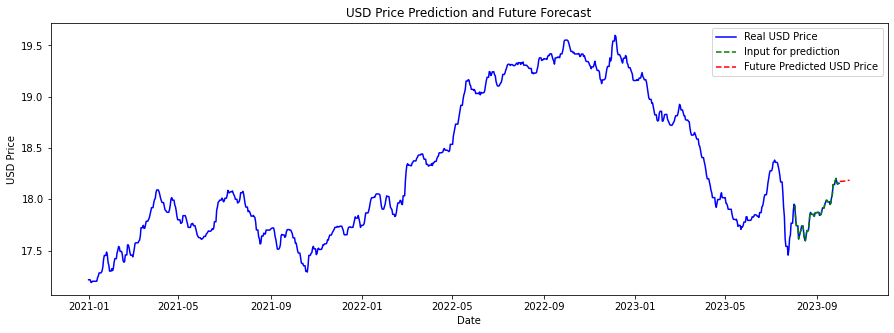

In [58]:
def plot_future_predictions(actual, last_n_actual, predicted_future):
    plt.figure(figsize=(15, 5))
    
    # Plot the actual prices up to the last available day
    plt.plot(actual.index, actual.values, color="blue", label="Real USD Price")
    
    # Plot the last N days leading up to our first prediction (for continuity)
    last_n_days_index = pd.date_range(end=actual.index[-1], periods=len(last_n_actual))
    plt.plot(last_n_days_index, last_n_actual, color="green", linestyle='--', label="Input for prediction")
    
    # Plot the future predictions
    future_dates = pd.date_range(start=actual.index[-1] + pd.Timedelta(days=1), periods=len(predicted_future))
    plt.plot(future_dates, predicted_future, color="red", linestyle='--', label="Future Predicted USD Price")
    
    plt.title("USD Price Prediction and Future Forecast")
    plt.xlabel("Date")
    plt.ylabel("USD Price")
    plt.legend()
    plt.show()

# Now let's plot everything together
plot_future_predictions(df_usd['USD'], last_values.flatten(), predicted_prices)


### first test

In [59]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Create traces for the actual and predicted prices
actual_trace = go.Scatter(
    x=df_usd.index,
    y=df_usd['USD'],
    mode='lines',
    name='Real USD Price'
)

input_trace = go.Scatter(
    x=pd.date_range(end=df_usd.index[-1], periods=n_steps),
    y=last_values.flatten(),
    mode='lines',
    name='Input for prediction',
    line=dict(dash='dot')
)

future_trace = go.Scatter(
    x=pd.date_range(start=df_usd.index[-1] + pd.Timedelta(days=1), periods=len(predicted_prices)),
    y=predicted_prices,
    mode='lines',
    name='Future Predicted USD Price',
    line=dict(dash='dot')
)

data = [actual_trace, input_trace, future_trace]

layout = go.Layout(
    title='USD Price Prediction and Future Forecast',
    xaxis=dict(title='Date'),
    yaxis=dict(title='USD Price')
)

fig = go.Figure(data=data, layout=layout)

# Plot the figure
iplot(fig)
